## What is the global trend in the cotton trading area in the last 10 years? ##

Let's clrean up the Foreign Agricultural Service dataset about cotton and display an overall picture.

In [6]:
import pandas as pd
df_global_cotton_trade = pd.read_csv("psd_cotton.csv")  
cleaned_data = df_global_cotton_trade[df_global_cotton_trade['Market_Year'] >= 2005]
cleaned_data = cleaned_data.drop(columns=['Calendar_Year'])

#accessible colors
colors = [
    "#606c38",  # Brazil - olive green (keep)
    "#E07B39",  # India - stronger earthy orange, avoids confusion with greens
    "#86A641",  # China - olive yellow-green, distinct from Brazil’s darker green
    "#1A3C28",  # United States - deep green-black (instead of pure black)
    "#B88A4F",  # Pakistan - warm ochre, higher contrast than beige
    "#7C3F00",  # Extra earthy brown if needed
]
print(cleaned_data['Attribute_Description'].unique())


['Area Harvested' 'Beginning Stocks' 'Domestic Use' 'Ending Stocks'
 'Exports' 'Imports' 'Loss' 'Production' 'Stocks-to-Use'
 'Total Distribution' 'Total Supply' 'Yield']


This is a legend of what the different attrubutes of out dataset represent.
- **Area Harvested** → Land actually harvested for cotton
- **Beginning Stocks** → Cotton carried over from previous season’s ending stocks
- **Domestic Use** → Cotton consumed by domestic mills within a country
- **Ending Stocks** → Cotton remaining in inventory at the close of season
- **Exports** → Cotton shipments sent abroad during the marketing year
- **Imports** → Cotton shipments brought into the country during the year
- **Loss** → Loss in PS&D datasets does not always mean physical loss. It represents adjustments needed to balance the supply-demand equation (if the value is positive, actual or estimated physical loss)
- **Production** → Cotton lint output from harvested fields during the season
- **Stocks-to-Use** → Ending stocks compared with domestic use and exports
- **Total Distribution** → Domestic use plus exports plus losses of cotton
- **Total Supply** → Beginning stocks plus production plus imports available
- **Yield** → Production of cotton lint per unit of harvested area

First of all, we could transform the dataset by adding as many columns as the unique attributes we listed here, so that the data will be more easy to access per country and per year.
Having this attributes, we could startign by displaying the total production of cotton and catch the first 5 countires in the world.

In [4]:
pivoted_data = cleaned_data.pivot_table(
    index=['Commodity_Code', 'Commodity_Description', 'Country_Code', 'Country_Name', 'Market_Year', 'Month'],
    columns='Attribute_Description',
    values=['Unit_Description', 'Value'],
    aggfunc='first'
)

pivoted_data.columns = [f'{attr}_{col}' for col, attr in pivoted_data.columns]
pivoted_data.reset_index(inplace=True)
pivoted_data.drop(columns=['Attribute_ID'], errors='ignore', inplace=True)
pivoted_data.to_csv('transformed_psd_cotton.csv', index=False)

/var/folders/fx/4n7zrjcn0ng53w2cl_t87vp80000gn/T/ipykernel_55518/480522574.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.08, 1, 0.95])


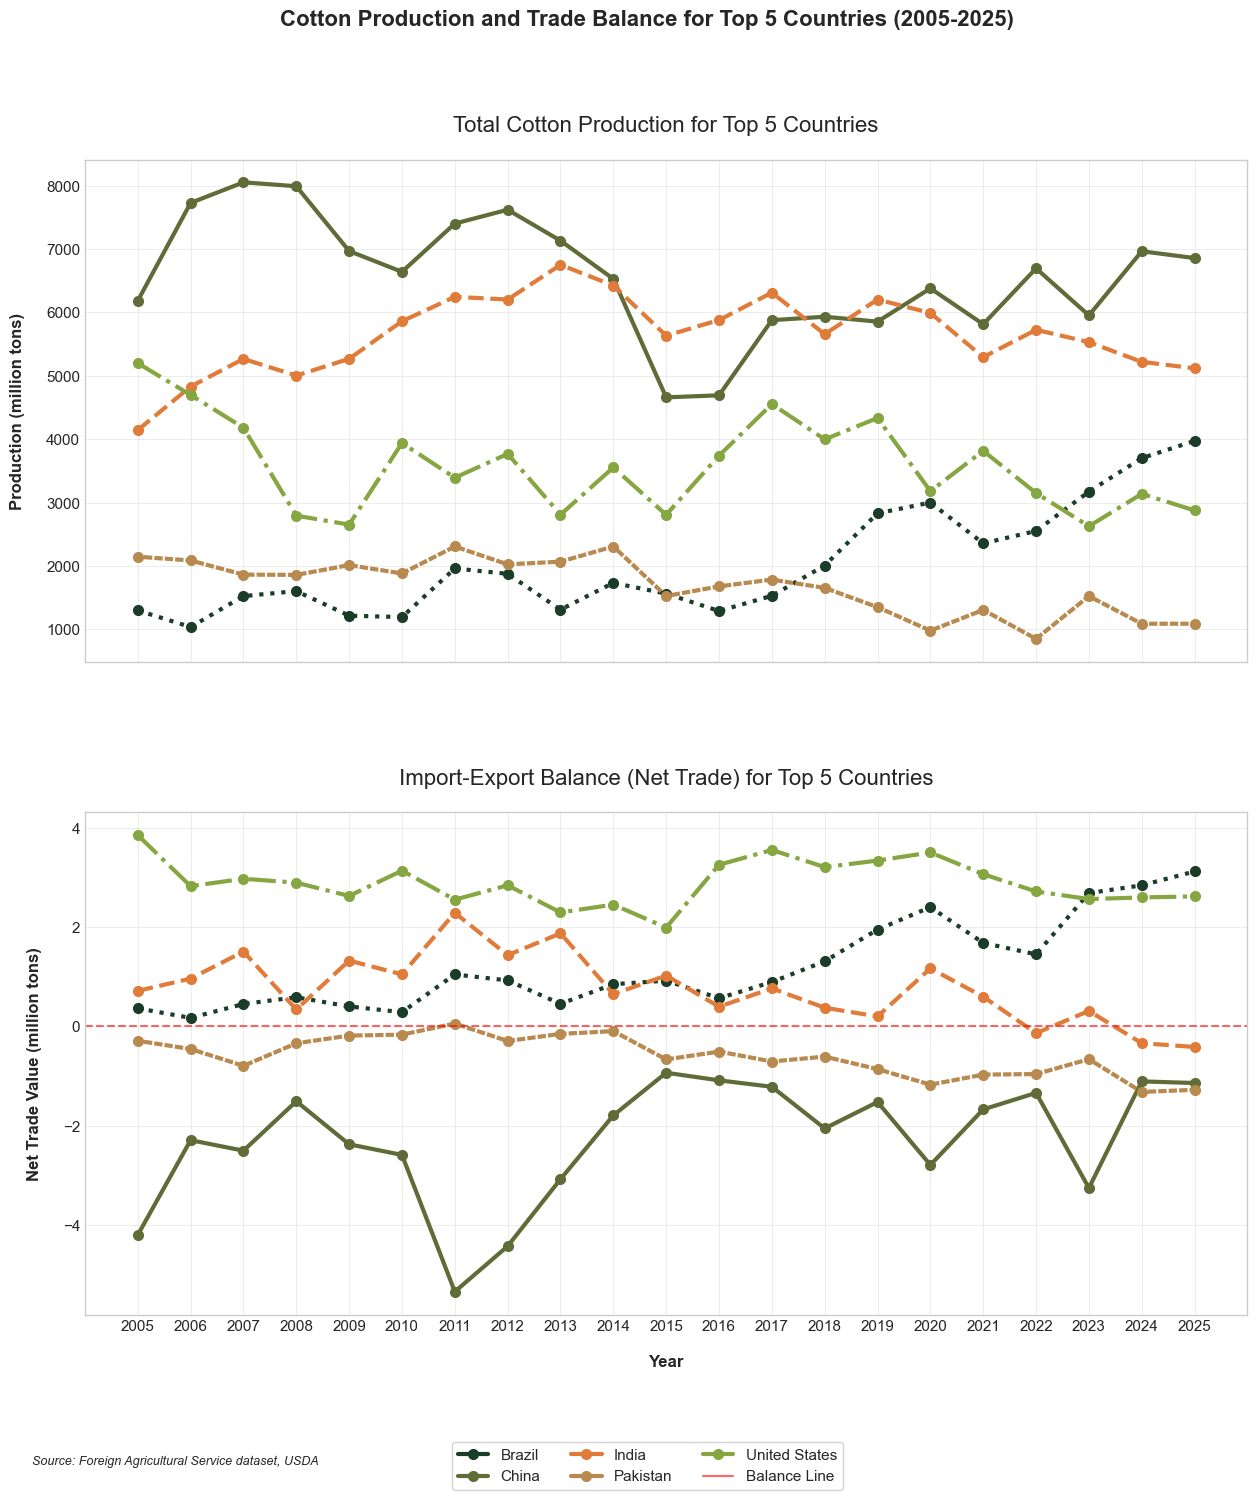

In [21]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(2, 1, figsize=(15, 15), sharex=True, gridspec_kw={'hspace': 0.3})

pivoted_data['Area_Harvested_ha'] = pivoted_data['Area Harvested_Value'] * 1000 # now in ha
pivoted_data['Loss_kg'] = pivoted_data['Loss_Value'].apply(lambda x: x * 218 if x > 0 else 0) # now in kg, avoiding negative corrections

# Production_tot = (Yield × Area Harvested)-Loss in million tons
pivoted_data['Production_tot'] = ((pivoted_data['Yield_Value'] * pivoted_data['Area_Harvested_ha']) - pivoted_data['Loss_kg'])/ 1_000_000
top_countries = pivoted_data.groupby('Country_Name')['Production_tot'].sum().nlargest(5).index
df_top5 = pivoted_data[pivoted_data['Country_Name'].isin(top_countries)].copy()

# line styles for accessibility
line_styles = ['-', '--', '-.', ':', (1, (2, 0.5, 2, 0.5))]  
style_map = {country: style for country, style in zip(top_countries, line_styles)}

color_map = {country: color for country, color in zip(top_countries, colors)}
df_top5.to_csv('top_5_prod_countires.csv', index=False)

# calculate net trade (Import-Export balance)
df_top5.loc[:, 'Net_Trade'] = (df_top5['Exports_Value'] - df_top5['Imports_Value']).apply(lambda x: x * 218)/ 1_000_000


# total Production for the top 5 countries
axes[0].set_title('Total Cotton Production for Top 5 Countries', pad=20, fontsize=16)
for country in df_top5['Country_Name'].unique():
    country_data = df_top5[df_top5['Country_Name'] == country]
    axes[0].plot(
        country_data['Market_Year'],
        country_data['Production_tot'],
        label=country,
        linewidth=3,
        marker='o',
        markersize=7,
        color=color_map[country],
        linestyle=style_map[country]
    )
axes[0].set_ylabel('Production (million tons)', fontsize=12, fontweight='bold', labelpad=15)
axes[0].tick_params(axis='both', labelsize=11)

# total Net Trade for the same top 5 countries
axes[1].set_title('Import-Export Balance (Net Trade) for Top 5 Countries', pad=20, fontsize=16)
for country in df_top5['Country_Name'].unique():
    country_data = df_top5[df_top5['Country_Name'] == country]
    axes[1].plot(
        country_data['Market_Year'],
        country_data['Net_Trade'],
        linewidth=3,
        marker='o',
        markersize=7,
        label=country,
        color=color_map[country],
        linestyle=style_map[country]
    )
axes[1].axhline(0, color='red', linestyle='--', alpha=0.6, linewidth=1.5, label='Balance Line')
axes[1].set_xlabel('Year', fontsize=12, fontweight='bold', labelpad=15)
axes[1].set_ylabel('Net Trade Value (million tons)', fontsize=12, fontweight='bold', labelpad=15)
axes[1].tick_params(axis='both', labelsize=11)

years = df_top5['Market_Year'].unique()
axes[0].set_xticks(years)
axes[1].set_xticks(years)

# adding both vertical and horizontal subtle grid
axes[0].grid(True, axis='both', linestyle='-', linewidth=0.5, alpha=0.5)
axes[1].grid(True, axis='both', linestyle='-', linewidth=0.5, alpha=0.5)

plt.suptitle('Cotton Production and Trade Balance for Top 5 Countries (2005-2025)', 
             fontsize=16, y=0.98, fontweight='bold')

# legend formatting
lines = []
labels = []
for country in df_top5['Country_Name'].unique():
    line, = axes[0].plot([], [], linewidth=3, marker='o', markersize=7, color=color_map[country], label=country)
    lines.append(line)
    labels.append(country)
line, = axes[0].plot([], [], color='red', alpha=0.6, linewidth=1.5, label='Balance Line')
lines.append(line)
labels.append('Balance Line')

legend = fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 0.03), 
                    ncol=3, fontsize=11, frameon=True, framealpha=0.95, 
                    edgecolor='lightgray')

fig.text(0.09, 0.01, "Source: Foreign Agricultural Service dataset, USDA", 
         fontsize=9, style='italic', ha='left')

plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.show()

This is interesting: China has a weird trend goin on, with spikes and unexpected curves. 

### What happened there, around 2010-2016? Are the production and the imports shifts correlated? ###

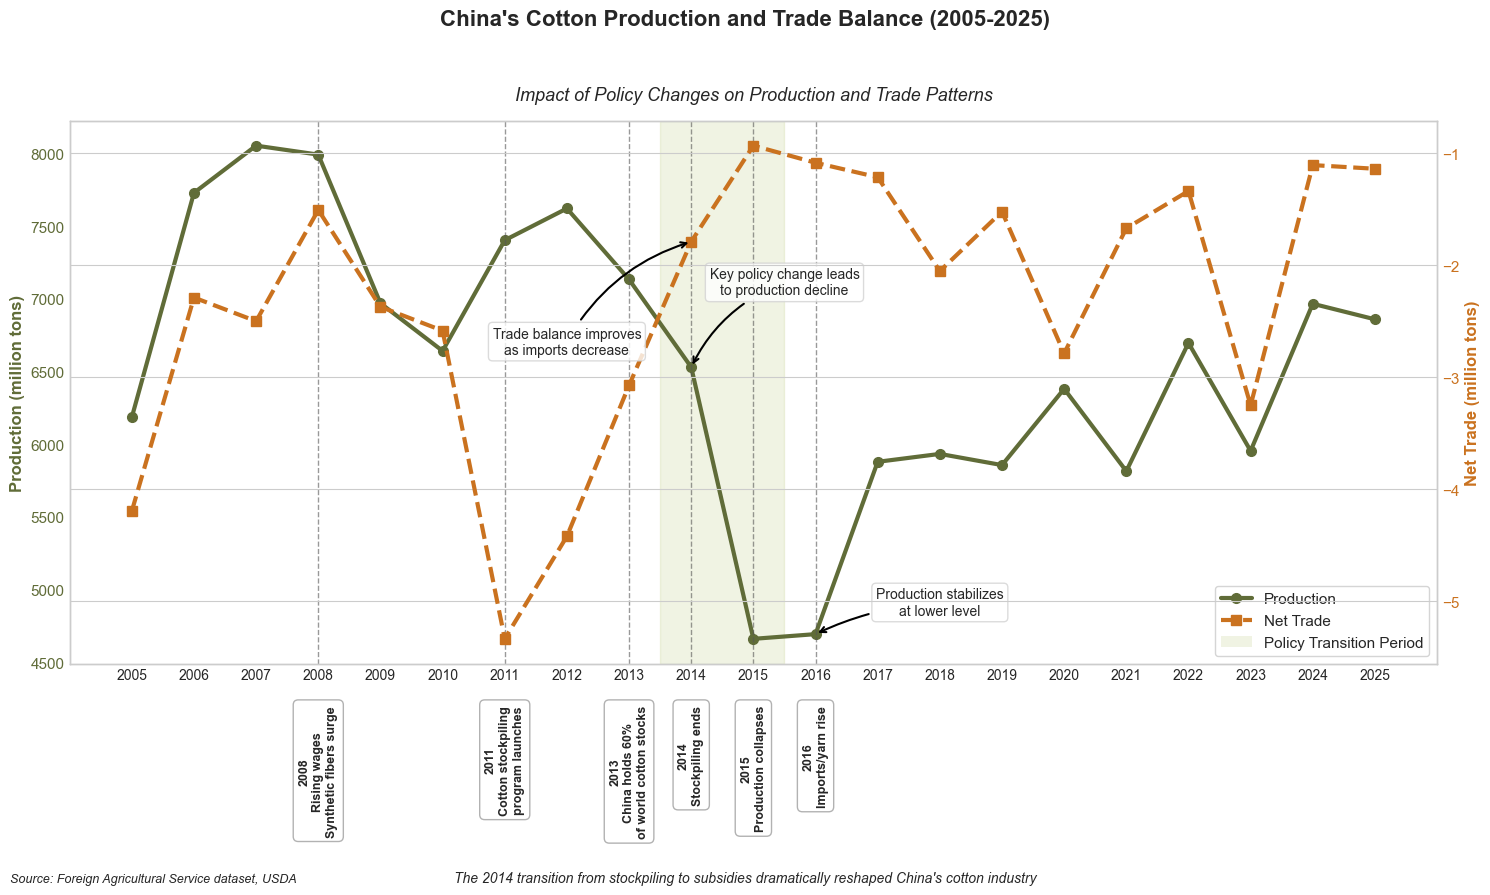

In [25]:
import matplotlib.pyplot as plt

# style
plt.style.use('seaborn-v0_8-whitegrid')

# data for China only
china_data = df_top5[df_top5['Country_Name'] == 'China']
max_y1 = max(china_data['Production_tot']) * 1.05
min_y1 = min(china_data['Production_tot']) * 0.95
y_range = max_y1 - min_y1

# two y-axes
fig, ax1 = plt.subplots(figsize=(15, 9))

# accessible palette
prod_color = '#606c38'  
trade_color = '#ca721f'  
highlight_color = '#A0B046'  
annotation_color = '#000000'  

# axis 1 = production, blue
ax1.set_ylabel('Production (million tons)', fontsize=12, fontweight='bold', color=prod_color)
line1 = ax1.plot(china_data['Market_Year'], china_data['Production_tot'], 
                 color=prod_color, linewidth=3, marker='o', markersize=7, label='Production')
ax1.tick_params(axis='y', labelcolor=prod_color, labelsize=11)

# axis 2 = net trade, orange 
ax2 = ax1.twinx()
ax2.set_ylabel('Net Trade (million tons)', fontsize=12, fontweight='bold', color=trade_color)
line2 = ax2.plot(china_data['Market_Year'], china_data['Net_Trade'], 
                 color=trade_color, linestyle='--' , linewidth=3, marker='s', markersize=7, label='Net Trade')
ax2.tick_params(axis='y', labelcolor=trade_color, labelsize=11)

# timeline events
events = {
    2008: "Rising wages\nSynthetic fibers surge",
    2011: "Cotton stockpiling\nprogram launches",
    2013: "China holds 60%\nof world cotton stocks",
    2014: "Stockpiling ends",
    2015: "Production collapses",
    2016: "Imports/yarn rise"
}

years = sorted(china_data['Market_Year'].unique())
min_year, max_year = min(years), max(years)

# policy transition period, where we want the attention
transition_start = 2013.5
transition_end = 2015.5
ax1.axvspan(transition_start, transition_end, alpha=0.15, color=highlight_color, 
            label='Policy Transition Period')

# vertical reference lines for key policy years
for year in events.keys():
    if year in china_data['Market_Year'].values:
        ax1.axvline(x=year, color='#555555', linestyle='--', alpha=0.6, linewidth=1)

ax1.set_xticks(years)

# Add event labels below the graph
for year in events.keys():
    if year in china_data['Market_Year'].values:
        # using (min_y1*0.9) to prevent dynamic adjustments from matplotlib
        ax1.text(year, min_y1*0.95, f"{int(year)}\n{events[year]}", 
                ha='center', va='top', fontsize=9, fontweight='bold',
                bbox=dict(facecolor='white', alpha=0.9, edgecolor='#aaaaaa', 
                          boxstyle='round,pad=0.4', linewidth=1),
                rotation=90)

# key insight for production drop
drop_year = 2014
drop_value = china_data[china_data['Market_Year']==drop_year]['Production_tot'].values[0]
ax1.annotate('Key policy change leads\nto production decline',
            xy=(drop_year, drop_value),
            xytext=(drop_year+1.5, drop_value+500),
            arrowprops=dict(arrowstyle='->', color=annotation_color, lw=1.5, 
                           connectionstyle="arc3,rad=.2"),
            fontsize=10, ha='center', bbox=dict(facecolor='white', alpha=0.8, 
                                             edgecolor='lightgray', boxstyle='round,pad=0.3'))

# key insight for production drop trade balance
trade_year = 2014
trade_value = china_data[china_data['Market_Year']==trade_year]['Net_Trade'].values[0]
ax2.annotate('Trade balance improves\nas imports decrease',
            xy=(trade_year, trade_value),
            xytext=(trade_year-2, trade_value-1),
            arrowprops=dict(arrowstyle='->', color=annotation_color, lw=1.5,
                           connectionstyle="arc3,rad=-.2"),
            fontsize=10, ha='center', bbox=dict(facecolor='white', alpha=0.8,
                                             edgecolor='lightgray', boxstyle='round,pad=0.3'))

# key insight for production recovery
recovery_year = 2016
ax1.annotate('Production stabilizes\nat lower level',
            xy=(recovery_year, china_data[china_data['Market_Year']==recovery_year]['Production_tot'].values[0]),
            xytext=(recovery_year+2, min_y1+400),
            arrowprops=dict(arrowstyle='->', color=annotation_color, lw=1.5,
                           connectionstyle="arc3,rad=.1"),
            fontsize=10, ha='center', bbox=dict(facecolor='white', alpha=0.8,
                                             edgecolor='lightgray', boxstyle='round,pad=0.3'))

# remove visible grid, here is just confusing
ax1.grid(False, axis='y')
ax1.grid(False, axis='x') 

# legend
lines = line1 + line2 + [plt.Rectangle((0,0), 1, 1, fc=highlight_color, alpha=0.15)]
labels = ['Production', 'Net Trade', 'Policy Transition Period']
legend = ax1.legend(lines, labels, loc='lower right', fontsize=11, frameon=True, 
                   framealpha=0.95, edgecolor='lightgray')

# title and subtitle
plt.suptitle("China's Cotton Production and Trade Balance (2005-2025)", 
          fontsize=16, y=0.98, fontweight='bold')
plt.title("Impact of Policy Changes on Production and Trade Patterns", 
          fontsize=13, style='italic', pad=15)

fig.text(0.01, 0.01, "Source: Foreign Agricultural Service dataset, USDA", 
         fontsize=9, style='italic', ha='left')
fig.text(0.5, 0.01, "The 2014 transition from stockpiling to subsidies dramatically reshaped China's cotton industry", 
         fontsize=10, ha='center', style='italic')

plt.subplots_adjust(bottom=0.25)
plt.tight_layout(rect=[0, 0.04, 1, 0.95])  
plt.show()

Through our analysis, we saw that China’s cotton industry was shaped more by government policies than by falling demand. When we compared production and net trade trends across countries, the sharp fluctuations in China’s data stood out. 

By a brief online research about internal policies of China, we discovered the generating spark of this interesting trend.
Looking at the detailed timeline, we linked these changes to the 2011–2013 stockpiling program, when the government bought cotton at high fixed prices. This policy kept farmers planting but made domestic cotton too expensive for mills, which turned instead to cheaper imports. As a result, China built up huge reserves and distorted the global market. 

In our calculations, production was defined as yield multiplied by harvested area, minus the reported losses. The positive values for loss indicate not only balancing adjustments but also the substantial physical deterioration of cotton during the stockpiling years. As storage costs escalated, large volumes of cotton held in warehouses began to **rot**, and this deterioration is clearly captured in the data as higher recorded losses, reducing the effective production available for use.

Critically, a reserve warehouse caught fire in 2013, destroying about 23,000 tonnes of cotton (about ¥450 million or ~$70 million worth). Source: https://www.chinadaily.com.cn/china/2013-07/04/content_16729918.htm

By 2014, we observed a sudden break in the data, which matched the end of stockpiling and the start of targeted subsidies in Xinjiang (a region "spared" by the internal policies). Production collapsed in eastern provinces while Xinjiang remained dominant thanks to continued support. At the same time, our analysis of trade balance trends showed how China increasingly relied on imported cotton and yarn, while the rise of synthetic fibers reduced the share of cotton in textiles.  

From these comparisons and timelines, we concluded that the fall in China’s cotton production was not caused by weaker demand, but by the unsustainable policies of stockpiling and the structural shift toward subsidies, imports, and synthetics.  
